In [1]:
import sys
import os 
from os import path,listdir
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from collections import Counter
import random
import matplotlib
import matplotlib.patches as mpatches
import pickle
import json

### Dictionaris
with open('dictionaries.json') as f:
    dictionaries = json.load(f)

In [3]:
output_pickle = 'graphs.pickle'
input_path = './classification_25'
files = [x for x in listdir(input_path) if x.endswith('.classification')]
files

['hg38tomm10.classification',
 'hg38todanrer10.classification',
 'danrer10tomm10.classification',
 'mm10tohg38.classification',
 'danrer10tohg38.classification',
 'mm10todanrer10.classification']

## Load all genes

In [4]:
ALL_GENES = []
for input_file in files:
    org_source = input_file.split('.')[0].split('to')[0]
    df = pd.read_csv(path.join(input_path,input_file),sep='\t',names=['gene_source','e_class','g_class','gene_exon','x1','gene_gene','x2'])
    ALL_GENES+= [(org_source,x) for x in list(df['gene_source'].unique())]
ALL_GENES = sorted(set(ALL_GENES))
#print(ALL_GENES[:100])

## Create all edges

In [5]:
EDGES_EXON = []
EDGES_GENE = []
for input_file in files:    
    org_source = input_file.split('.')[0].split('to')[0]
    org_dest = input_file.split('.')[0].split('to')[1]
    print(org_source,org_dest)
    df = pd.read_csv(path.join(input_path,input_file),sep='\t',names=['gene_source','e_class','g_class','gene_exon','x1','gene_gene','x2'])
    df = df[['gene_source','gene_exon','gene_gene']]
    df['gene_exon_list'] = df['gene_exon'].apply(lambda x:[y for y in x.split(';') if y != '.'])
    df['gene_gene_list'] = df['gene_gene'].apply(lambda x:[y for y in x.split(';') if y != '.'])
    #df.head()
    for row in df.itertuples():
        gene_source = row.gene_source
        for gene_exon in row.gene_exon_list:
            edge =((org_source,gene_source),(org_dest,gene_exon)) 
            EDGES_EXON.append(edge)
        for gene_gene in row.gene_gene_list:
            edge =((org_source,gene_source),(org_dest,gene_gene)) 
            EDGES_GENE.append(edge)
    print(EDGES_GENE[:3])

hg38 mm10
[(('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131653.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131648.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT067255.2'))]
hg38 danrer10
[(('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131653.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131648.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT067255.2'))]
danrer10 mm10
[(('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131653.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131648.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT067255.2'))]
mm10 hg38
[(('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131653.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131648.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT067255.2'))]
danrer10 hg38
[(('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131653.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT131648.1')), (('hg38', 'NONHSAT143776.2'), ('mm10', 'NONMMUT067255.2'))]
mm10 danrer10
[(('hg38', 'NONHSAT

## Create and pickle graphs

In [9]:
G_exon = nx.DiGraph()
G_exon.add_nodes_from(ALL_GENES)
G_exon.add_edges_from(EDGES_EXON)
G_exon_undirected = G_exon.to_undirected()
#components_exon = sorted(list(nx.connected_component_subgraphs(G_exon_undirected)),key=lambda x:-len(x))
components_exon = sorted(list(G_exon_undirected.subgraph(c) for c in nx.connected_components(G_exon_undirected)),key=lambda x:-len(x))
print('EXON graph: %d nodes, %d edges, %d connected_components'%(nx.number_of_nodes(G_exon),
    nx.number_of_edges(G_exon),len(components_exon)),file=sys.stderr)

G_gene = nx.DiGraph()
G_gene.add_nodes_from(ALL_GENES)
G_gene.add_edges_from(EDGES_GENE)
G_gene_undirected = G_gene.to_undirected()
#components_gene = sorted(list(nx.connected_component_subgraphs(G_gene_undirected)),key=lambda x:-len(x))
components_gene = sorted(list(G_gene_undirected.subgraph(c) for c in nx.connected_components(G_gene_undirected)),key=lambda x:-len(x))
print('GENE graph: %d nodes, %d edges, %d connected_components'%(nx.number_of_nodes(G_gene),
    nx.number_of_edges(G_gene),len(components_gene)),file=sys.stderr)

EXON graph: 255964 nodes, 184357 edges, 166782 connected_components
GENE graph: 295222 nodes, 349632 edges, 138206 connected_components


## Export pickle

In [23]:
import pickle
data = {'G_gene':G_gene,'G_gene_udirected':G_gene_undirected,'components_gene':components_gene,
        'G_exon':G_exon,'G_exon_udirected':G_exon_undirected,'components_exon':components_exon}
with open(output_pickle, 'wb') as f:    
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
print('Wrote',output_pickle,file=sys.stderr)

Wrote graphs.pickle


## Load pickle

In [ ]:
import pickle
pickle_in = open("graphs.pickle","rb")
data = pickle.load(pickle_in)

## Calculate statistics

In [16]:
def read_config(file_name):
    config_df =  pd.read_csv(file_name, sep='\t', na_filter= False)
    return(config_df)

config_df = read_config("./config")
config_df.set_index("specie", inplace = True)
config_df["default"] = False
for i in config_df.index:
    if not config_df.loc[i]["annotation"]:
        default_gtf = dictionaries["gtfs_ensembl_r98"][config_df.loc[i]["assembly_version"].lower()].split("/")[-1]
        config_df.at[i, 'default'] = True
        config_df.at[i, 'annotation'] = default_gtf
    if not config_df.loc[i]["chainmap"]:
        chainmaps = []
        for j in config_df.index:
            if i!=j:
                default_chainmap_path = dictionaries["chain_maps"][config_df.loc[i]["assembly_version"].lower()][config_df.loc[j]["assembly_version"].lower()]
                default_chainmap_name = default_chainmap_path.split("/")[-1]
                chainmaps.append(default_chainmap_name)
        config_df.at[i, 'chainmap'] = ",".join(chainmaps)

assemblies = [ x.lower() for x in list(config_df["assembly_version"]) ]
#assemblies = ['hg38','mm10','danrer11']

def get_clusters_stats(components,G,output_path=None):
    if not path.exists(output_path):
        os.makedirs(output_path)
    output_cluster_stats = path.join(output_path,'cluster_stats.csv')
    output_cluster_genes = path.join(output_path,'cluster_genes.csv')    
    org_all_count = Counter([x[0] for x in G.nodes()])
    total_genes = len(G.nodes())        
    header_stats = ['cluster_id','node_count','per_total','edge_count','bidirectional_count',
              'has_hg38','count_hg38','per_cluster_hg38','per_total_hg38',
             'has_mm10','count_mm10','per_cluster_mm10','per_total_mm10',
             'has_danrer10','count_danrer10','per_cluster_danrer10','per_total_danrer10',]
    header_genes = ['assembly','gene','cluster_id', 'in_degree','out_degree']
    o1 = open(output_cluster_stats,'w')
    o1.write('\t'.join(header_stats)+'\n')
    o2 = open(output_cluster_genes,'w')
    o2.write('\t'.join(header_genes)+'\n')
    for idx,c in enumerate(components):
        g = G.subgraph(c)
        nodes = g.nodes()
        edges = g.edges()    
        edges_set = set(edges)
        is_bidirectional = [1 if (v[1],v[0]) in edges_set else 0 for v in edges]
        bidirectional = sum(is_bidirectional)
        org_comp_count_ugly = Counter([x[0] for x in nodes])
        org_comp_count = {k:v for k,v in org_comp_count_ugly.items()}
        for a in assemblies:
            if a not in org_comp_count:
                org_comp_count[a] = 0
        data = {'cluster_id': str(idx),
                'node_count': str(len(nodes)),
                'per_total': '%.2f'%(100*len(nodes)/total_genes),
                'edge_count': str(len(edges)),
                'bidirectional_count': str(bidirectional),                
                'has_hg38': str(int(org_comp_count['hg38']>0)),
                'count_hg38': str(org_comp_count['hg38']),
                'per_cluster_hg38': '%.2f'%(100*org_comp_count['hg38']/len(nodes)),
                'per_total_hg38': '%.2f'%(100*org_comp_count['hg38']/total_genes),
                'has_mm10': str(int(org_comp_count['mm10']>0)),
                'count_mm10': str(org_comp_count['mm10']),
                'per_cluster_mm10': '%.2f'%(100*org_comp_count['mm10']/len(nodes)),
                'per_total_mm10': '%.2f'%(100*org_comp_count['mm10']/total_genes),
                'has_danrer10': str(int(org_comp_count['danrer10']>0)),
                'count_danrer10': str(org_comp_count['danrer10']),
                'per_cluster_danrer10': '%.2f'%(100*org_comp_count['danrer10']/len(nodes)),
                'per_total_danrer10': '%.2f'%(100*org_comp_count['danrer10']/total_genes)}
        o1.write('\t'.join(data[x] for x in header_stats)+'\n')  
        for node in nodes:
            data2 = {'assembly': node[0],
                    'gene': node[1],
                     'cluster_id': str(idx),
                     'in_degree': str(g.in_degree(node)),
                     'out_degree': str(g.out_degree(node))}
            o2.write('\t'.join(data2[x] for x in header_genes)+'\n')
        #break
    o1.close()
    print('Wrote',output_cluster_stats,file=sys.stderr)
    o2.close()
    print('Wrote',output_cluster_genes,file=sys.stderr)

In [17]:
get_clusters_stats(components_gene,G_gene,'level_gene')

Wrote level_gene/cluster_stats.csv
Wrote level_gene/cluster_genes.csv


# Explorando clusters solo con aristas bidireccionales


In [20]:
G_gene_undirected_bi = G_gene.to_undirected(reciprocal=True)
#components_gene = sorted(list(nx.connected_component_subgraphs(G_gene_undirected_bi)),key=lambda x:-len(x))
components_gene = sorted(list(G_gene_undirected_bi.subgraph(c) for c in nx.connected_components(G_gene_undirected_bi)),key=lambda x:-len(x))
print('GENE graph: %d nodes, %d edges, %d connected_components'%(nx.number_of_nodes(G_gene),
    nx.number_of_edges(G_gene),len(components_gene)),file=sys.stderr)
print(len(components_gene[0]),len(components_gene[1]))

204 145


GENE graph: 295222 nodes, 349632 edges, 212965 connected_components


In [21]:
org_color = {'hg38':'lightgreen','mm10':'lightblue','danrer11':'yellow'}
def plot_component(g):
    fig,ax = plt.subplots(figsize=(8,8))
    nodes = g.nodes()
    edges = g.edges()    
    edges_set = set(edges)
    bidirectional = [True if (v[1],v[0]) in edges_set else False for v in edges]
    edge_color = ['red' if x else 'gray' for x in bidirectional]
    node_color = [org_color[x[0]] for x in nodes]
    labels = {x:x[1] for x in nodes} ############### cambiar x[1] por tu_dictionary[x[1]]!
    pos=nx.spring_layout(g)    
    nx.draw_networkx_nodes(g,pos,nodelist=nodes,node_color=node_color)
    nx.draw_networkx_edges(g,pos,edgelist=edges,edge_color=edge_color)
    nx.draw_networkx_labels(g,pos,labels,font_weight='bold')
    plt.legend(handles=[mpatches.Patch(color=v, label=k) for k,v in org_color.items()],
               bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [24]:
output_pickle = 'graphs.pickle'
with open(output_pickle,'rb') as f:
    data = pickle.load(f)
print(data.keys())

dict_keys(['G_gene', 'G_gene_udirected', 'components_gene', 'G_exon', 'G_exon_udirected', 'components_exon'])


In [25]:
G_gene = data['G_gene']
G_gene_udirected = data['G_gene_udirected']
components_gene = data['components_gene']
G_exon = data['G_exon']
G_exon_udirected = data['G_exon_udirected']
components_exon = data['components_exon']

## Plot subgraph

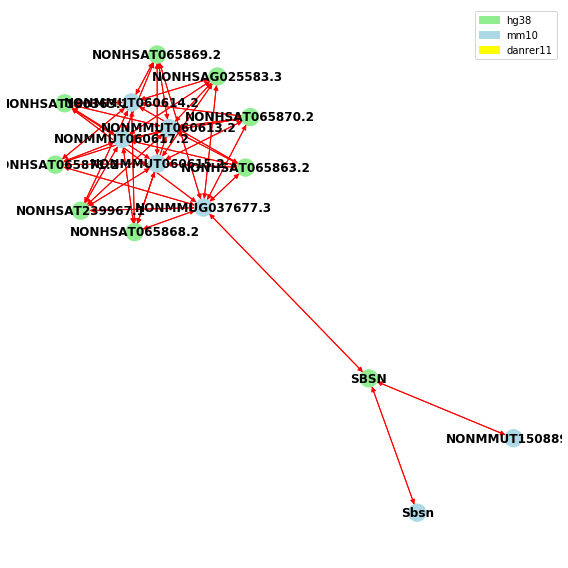

In [79]:
G = G_gene.subgraph(components_gene[500])
plot_component(G)

In [81]:
G = G_gene.subgraph(components_gene[1])
res = nx.algorithms.cycles.simple_cycles(G)
cycles = []
count = 0
for cycle in res:
    if len(cycle)<10:
        continue
    cycles.append((len(cycle),cycle))    
    count+=1
    if count==10:
        break

In [82]:
cycles = sorted(cycles,key=lambda x:-x[0])
print(cycles[0])

(12, [('mm10', 'NONMMUG016477.2'), ('hg38', 'NONHSAT091337.2'), ('mm10', 'NONMMUG016487.2'), ('hg38', 'NONHSAT091340.2'), ('mm10', 'NONMMUG061537.1'), ('hg38', 'NONHSAT091338.2'), ('mm10', 'NONMMUG016486.2'), ('hg38', 'NONHSAT196136.1'), ('mm10', 'Lsamp'), ('hg38', 'NONHSAG035832.2'), ('mm10', 'NONMMUG061463.1'), ('hg38', 'NONHSAT196134.1')])


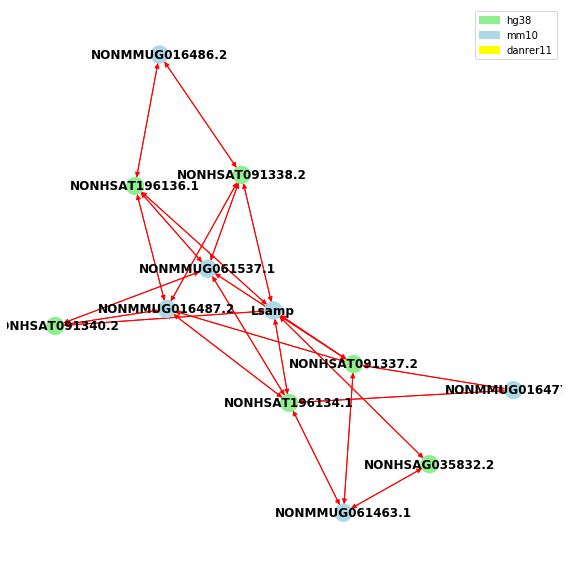

In [83]:
x = G_gene.subgraph(cycles[0][1])
plot_component(x)

In [84]:
by_out_degree = sorted([(node,x.out_degree(node)) for node in x.nodes() if node[0]=='hg38'],key=lambda x:-x[1])
by_out_degree

[(('hg38', 'NONHSAT091337.2'), 5),
 (('hg38', 'NONHSAT196134.1'), 5),
 (('hg38', 'NONHSAT091338.2'), 4),
 (('hg38', 'NONHSAT196136.1'), 4),
 (('hg38', 'NONHSAT091340.2'), 3),
 (('hg38', 'NONHSAG035832.2'), 2)]